In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import sklearn
import tensorflow as tf
from tensorflow import keras
from PIL import Image as im
from glob import glob
from sklearn.model_selection import train_test_split
import keras
#from tf.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Train Datasets Collection & Understanding**

In [ ]:
train_path = '/content/drive/MyDrive/Recycle or Non-recycle/train'

(1010, 224, 224, 3) (1010,)


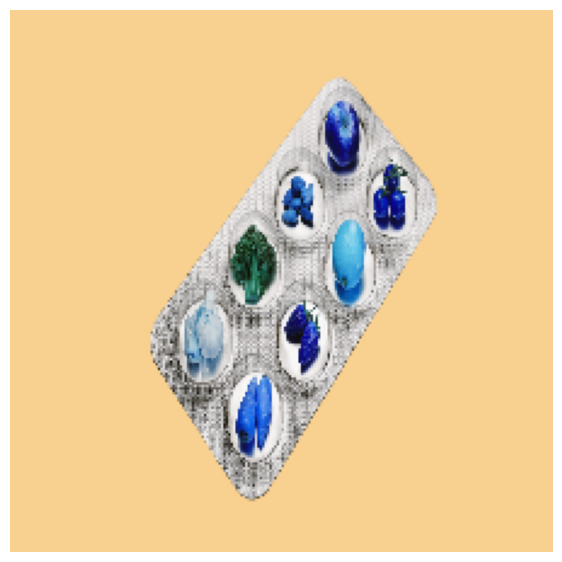

In [ ]:
class_names = sorted(os.listdir(train_path))
label_mapping = {name: i for i, name in enumerate(class_names)}

train_data = []
train_labels = []
for i in os.listdir(train_path):
  dir = train_path + '/' + i
  for j in os.listdir(dir):
    img_path = dir + '/' + j
    # Read image as 3-channel color image, ensuring consistent shape
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img is None:
        print(f"Warning: Could not read image {img_path}. Skipping.")
        continue
    img = cv2.resize(img,(224,224),interpolation = cv2.INTER_NEAREST)
    train_data.append(img)
    train_labels.append(label_mapping[i])

plt.figure(figsize=(7,10))
plt.axis('off')
plt.imshow(img)
train_data = np.array(train_data)
train_labels = np.array(train_labels)
print(train_data.shape, train_labels.shape)

## Training Datas Labels

In [ ]:
# Show the data classes
classes = os.listdir(train_path)
classes

['Recycle', 'Non-recycle']

### **Test Datasets Collection & Understanding**

In [ ]:
test_path = '/content/drive/MyDrive/Recycle or Non-recycle/test'

In [ ]:
import os
import cv2
import numpy as np

test_data = []
test_labels = []

# Your label dictionary example:
dict = {"Non-recycle": 0, "Recycle": 1}

for class_name in os.listdir(test_path):

    class_dir = os.path.join(test_path, class_name)

    # Skip if not a directory
    if not os.path.isdir(class_dir):
        continue

    for filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, filename)

        # Read image
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)

        # If failed to read → skip
        if img is None:
            print("⚠️ Cannot read file:", img_path)
            continue

        # Resize
        img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_NEAREST)

        # Store data
        test_data.append(img)
        test_labels.append(dict[class_name])

# Convert to numpy arrays
test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Final shape:")
print(test_data.shape, test_labels.shape)


⚠️ Cannot read file: /content/drive/MyDrive/Recycle or Non-recycle/test/Recycle/Copy of Copy of 5_Dimensions-Objects-Beverage-Containers-Soda-Bottle-2-Liter-Size-Comparison.svg
⚠️ Cannot read file: /content/drive/MyDrive/Recycle or Non-recycle/test/Recycle/Copy of 5_Dimensions-Objects-Beverage-Containers-Soda-Bottle-2-Liter-Size-Comparison.svg
Final shape:
(250, 224, 224, 3) (250,)


### **Data Augmentation part done on training Dataset**

In [ ]:
# this is the augmentation configuration we will use for training
# It generate more images using below parameters
training_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

# this is a generator that will read pictures found in
# at train_data_path, and indefinitely generate
# batches of augmented image data
training_data = training_datagen.flow_from_directory(train_path, # this is the target directory means give train directory path
                                      target_size=(224, 224), # all images will be resized to 224x224
                                      batch_size=32,
                                      class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

Found 1002 images belonging to 2 classes.


In [ ]:
# show augmented images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

### **Data Augmentation Visualization**

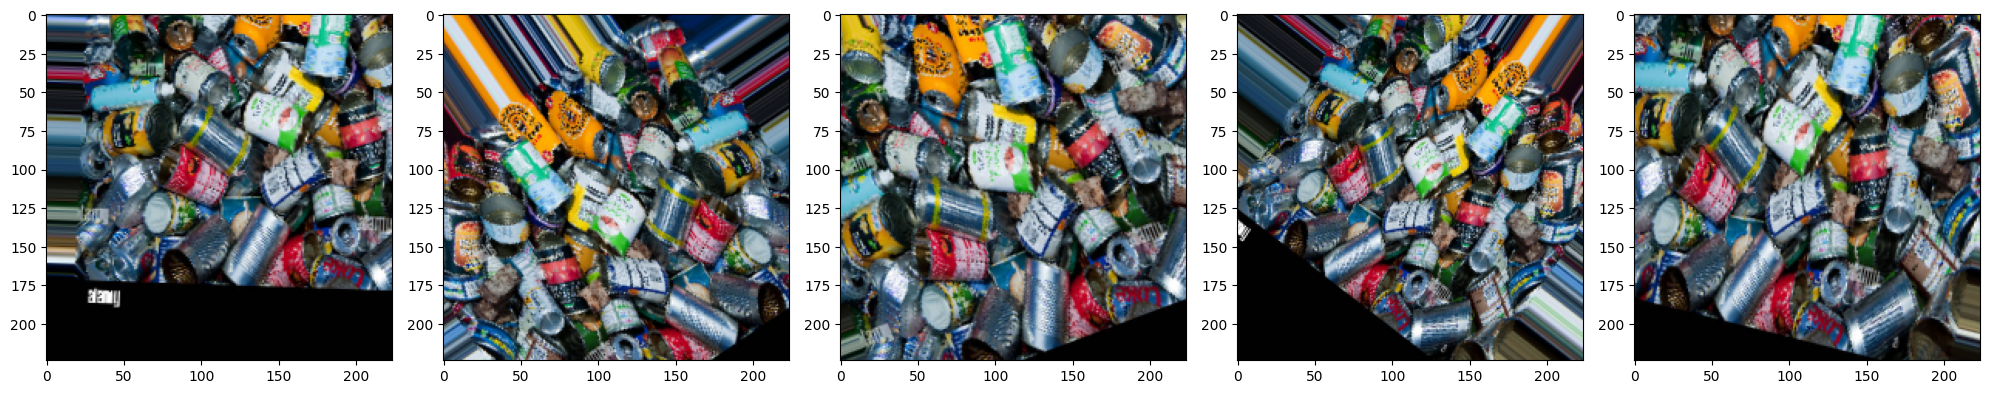

In [ ]:
# showing augmented images
images = [training_data[0][0][0] for i in range(5)]
plotImages(images)

Text(0, 0.5, 'Number of Traingn images')

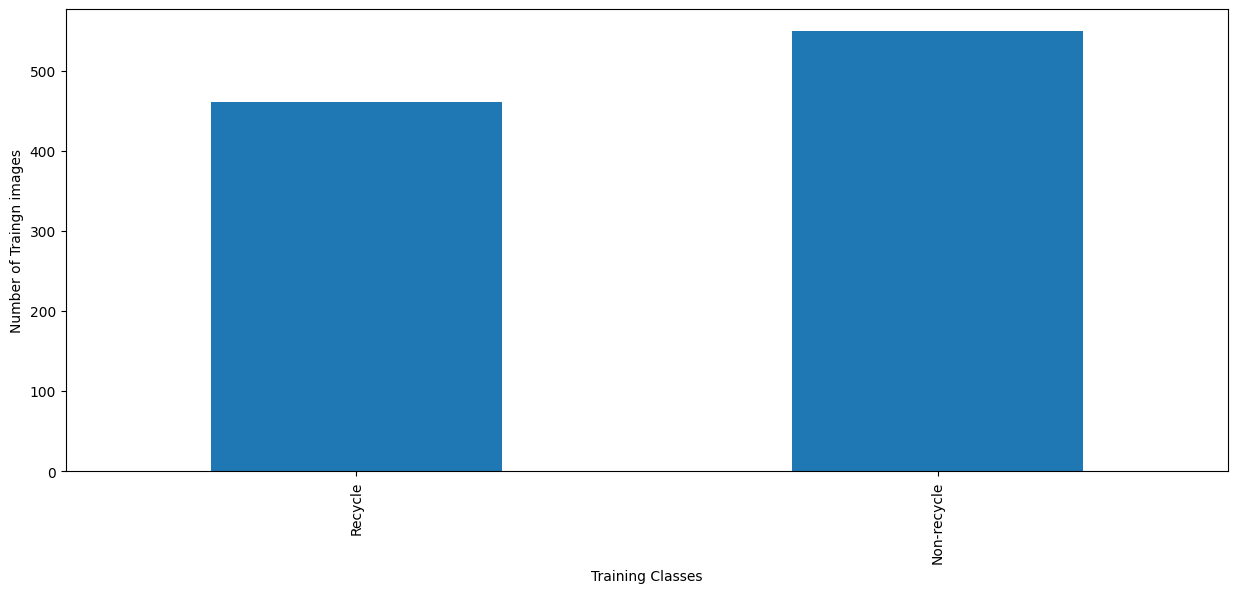

In [ ]:
# number of images in each class for training datasets
data_dic = {}
for folder in os.listdir(train_path):
    data_dic[folder] = len(os.listdir(train_path + '/' + folder))

data_df= pd.Series(data_dic)
plt.figure(figsize = (15, 6))
data_df.sort_values().plot(kind = 'bar')
plt.xlabel('Training Classes')
plt.ylabel('Number of Traingn images')

### **Data Augmentation part done on Testing Dataset**

In [ ]:
# this is the augmentation configuration we will use for training
# It generate more images using below parameters
testing_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# at train_data_path, and indefinitely generate
# batches of augmented image data
testing_data = testing_datagen.flow_from_directory(test_path, # this is the target directory means give train directory path
                                      target_size=(224, 224), # all images will be resized to 224x224
                                      batch_size=32,
                                      class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

Found 248 images belonging to 2 classes.


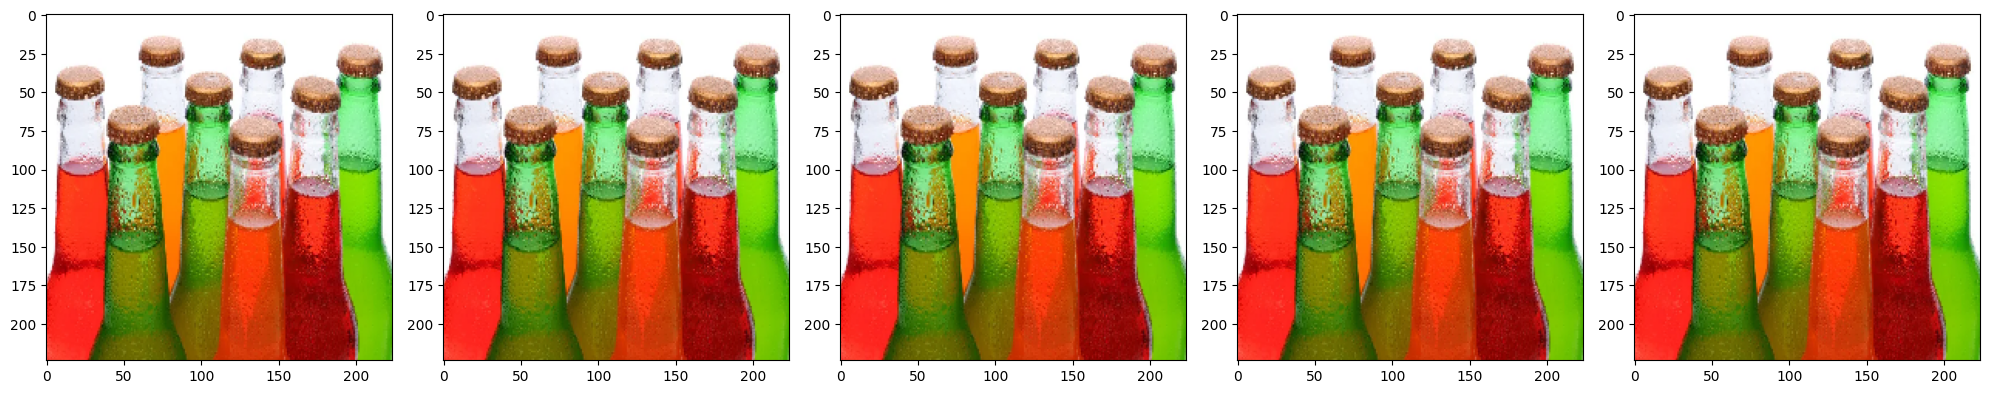

In [ ]:
# showing augmented images
images = [testing_data[1][0][0] for i in range(5)]
plotImages(images)

Text(0, 0.5, 'Number of Valedation images')

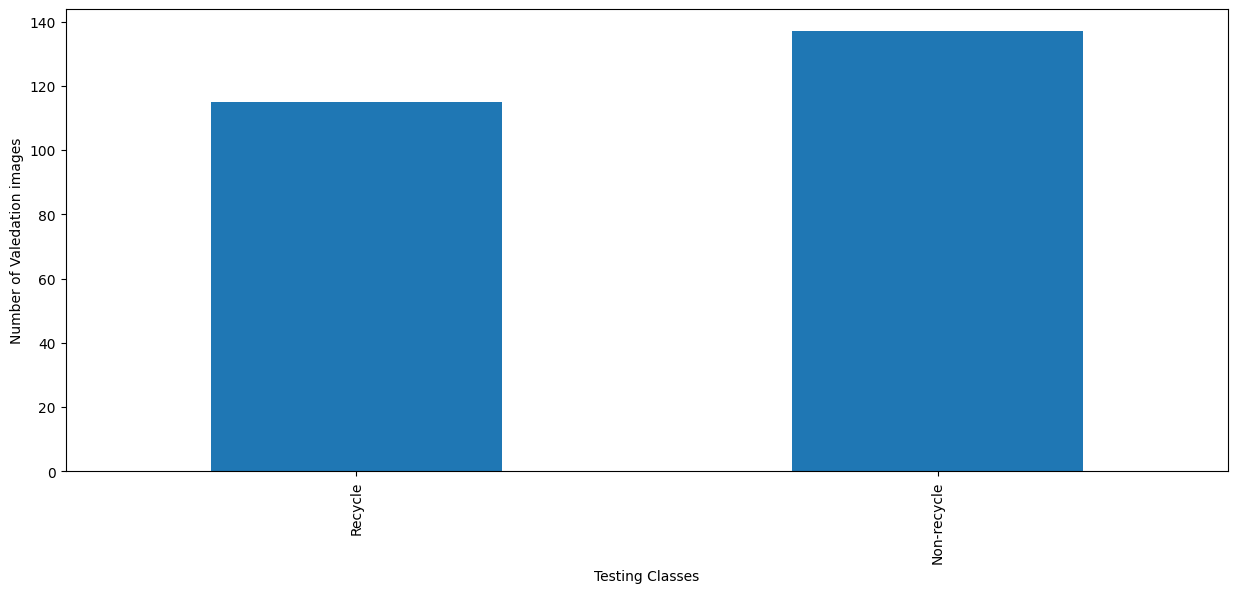

In [ ]:
# number of images in each class for training datasets
data_dic = {}
for folder in os.listdir(test_path):
    data_dic[folder] = len(os.listdir(test_path + '/' + folder))

data_df= pd.Series(data_dic)
plt.figure(figsize = (15, 6))
data_df.sort_values().plot(kind = 'bar')
plt.xlabel('Testing Classes')
plt.ylabel('Number of Valedation images')

## **CNN - VGG16 Architeture using Tranfer Learning**

In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:
'''
# Import label encoder
from sklearn import preprocessing
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
'''

from tensorflow.keras.utils import to_categorical

In [ ]:
train_labels.shape

(1010,)

In [ ]:
X_train = train_data
y_train = train_labels
X_test = test_data
y_test = test_labels


Y_train = (to_categorical(y_train))
Y_test = (to_categorical(y_test))
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1010, 224, 224, 3)
(1010, 2)
(250, 224, 224, 3)
(250, 2)


In [ ]:
# We build the base model
base_model = VGG16(input_shape=IMAGE_SIZE + [3],weights='imagenet', include_top=False)
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# We freeze every layer in our base model so that they do not train, we want that our feature extractor stays as before --> transfer learning
for layer in base_model.layers:
  layer.trainable = False
  print('Layer ' + layer.name + ' frozen.')


# We take the last layer of our the model and add it to our classifier
last = base_model.layers[-1].output
x = Flatten()(last)
#x = Dense(1000, activation='relu', name='fc1')(x)
#x = Dropout(0.3)(x)
prediction = Dense(len(os.listdir(train_path)), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=prediction)


Layer input_layer_1 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Layer block5_conv1 frozen.
Layer block5_conv2 frozen.
Layer block5_conv3 frozen.
Layer block5_pool frozen.


In [ ]:
# We compile the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])



In [ ]:
model.summary() # Tranfer Learning Summary

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │        50,178 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,764,866 (56.32 MB)

 Trainable params: 50,178 (196.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath = 'vgg16_model.weights.best.keras',
                               verbose = False,
                               save_best_only = True)

# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 4,
                           restore_best_weights = True,
                           mode = 'min')

In [ ]:
result_VGG_TF = model.fit(training_data,steps_per_epoch=len(training_data),epochs=5,callbacks=[early_stop, checkpointer],validation_data=testing_data,validation_steps=len(testing_data))

'''
# We start the training
epochs = 100
batch_size = 256
# We train it
result_VGG_TF = model.fit(X_train, Y_train,
                                    batch_size=batch_size,
                                    validation_data=(X_test, Y_test),
                                    epochs = 100)
                                    '''

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 988ms/step - accuracy: 0.7108 - loss: 0.6199 - val_accuracy: 0.7137 - val_loss: 0.8319
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 899ms/step - accuracy: 0.9006 - loss: 0.2768 - val_accuracy: 0.6815 - val_loss: 0.8538
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 892ms/step - accuracy: 0.8773 - loss: 0.2909 - val_accuracy: 0.8065 - val_loss: 0.6089
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 899ms/step - accuracy: 0.9244 - loss: 0.2128 - val_accuracy: 0.8105 - val_loss: 0.5739
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 894ms/step - accuracy: 0.9185 - loss: 0.2184 - val_accuracy: 0.7823 - val_loss: 0.6308


'\n# We start the training\nepochs = 100\nbatch_size = 256\n# We train it\nresult_VGG_TF = model.fit(X_train, Y_train,\n                                    batch_size=batch_size,\n                                    validation_data=(X_test, Y_test),\n                                    epochs = 100)\n                                    '

In [ ]:
probs = model.predict(testing_data,steps = len(testing_data), verbose = 1)


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 711ms/step


In [ ]:
preds = np.argmax(probs,axis = 1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Get the true labels in the order yielded by the generator
y_true_generator = testing_data.classes

# Ensure preds has the same length as y_true_generator
# (This is implicitly handled if probs was generated from testing_data)

print(classification_report(y_true_generator, preds))
print(confusion_matrix(y_true_generator, preds))

              precision    recall  f1-score   support

           0       0.54      0.53      0.54       135
           1       0.45      0.45      0.45       113

    accuracy                           0.50       248
   macro avg       0.49      0.49      0.49       248
weighted avg       0.50      0.50      0.50       248

[[72 63]
 [62 51]]


In [ ]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix

# Get the true labels in the order yielded by the generator
y_true_for_cm = testing_data.classes

cm = confusion_matrix(y_true_for_cm, preds)

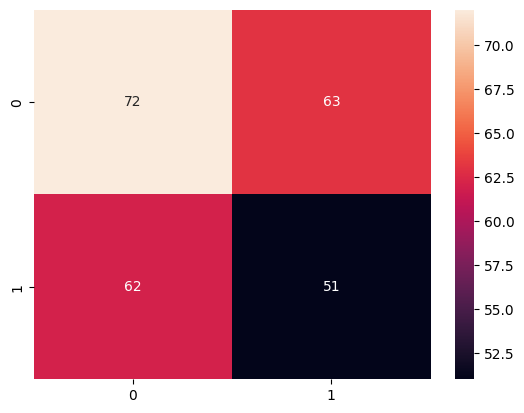

In [ ]:
import seaborn as sns
sns.heatmap(cm,annot=True)
plt.savefig('h1.png')

In [ ]:
# Calculate the Accuracy
from sklearn.metrics import accuracy_score

# Use the true labels yielded by the generator
y_true_for_accuracy = testing_data.classes

score = accuracy_score(y_true_for_accuracy, preds)
score

0.4959677419354839

In [ ]:
# We evaluate the accuracy and the loss in the test set
scores = model.evaluate(testing_data, steps = len(testing_data), verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 709ms/step - accuracy: 0.7974 - loss: 0.6368
Test loss: 0.573944628238678
Test accuracy: 0.8104838728904724


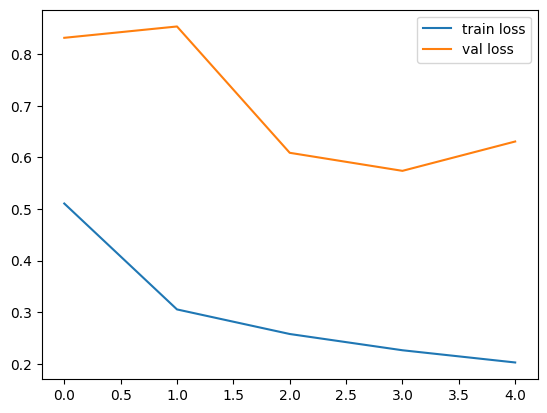

<Figure size 640x480 with 0 Axes>

In [ ]:
# loss
plt.plot(result_VGG_TF.history['loss'], label='train loss')
plt.plot(result_VGG_TF.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

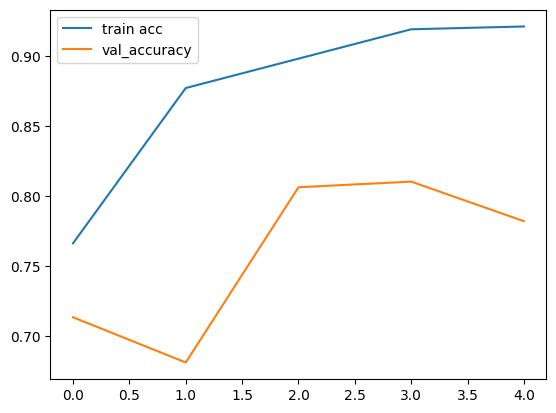

<Figure size 640x480 with 0 Axes>

In [ ]:
# accuracies
plt.plot(result_VGG_TF.history['accuracy'], label='train acc')
plt.plot(result_VGG_TF.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
y_pred = model.predict(testing_data)

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 645ms/step


In [ ]:
y_pred

array([[9.95190024e-01, 4.80993045e-03],
       [1.78674562e-03, 9.98213291e-01],
       [9.03179467e-01, 9.68205482e-02],
       [7.73194279e-06, 9.99992251e-01],
       [8.65995944e-01, 1.34004042e-01],
       [9.99582231e-01, 4.17775678e-04],
       [2.15507374e-04, 9.99784470e-01],
       [9.99987483e-01, 1.25330798e-05],
       [9.90539670e-01, 9.46037099e-03],
       [9.99082685e-01, 9.17308673e-04],
       [7.56699999e-04, 9.99243319e-01],
       [3.23124230e-01, 6.76875770e-01],
       [7.58807719e-01, 2.41192296e-01],
       [9.91013706e-01, 8.98630358e-03],
       [4.27903701e-03, 9.95720983e-01],
       [5.90055920e-02, 9.40994442e-01],
       [9.85760391e-01, 1.42395776e-02],
       [4.97505367e-02, 9.50249434e-01],
       [1.68752313e-01, 8.31247628e-01],
       [2.59832650e-01, 7.40167320e-01],
       [9.76059437e-01, 2.39405297e-02],
       [9.80653167e-01, 1.93468314e-02],
       [7.89385065e-02, 9.21061516e-01],
       [1.27588943e-01, 8.72411013e-01],
       [9.089685

In [ ]:
prediction = np.argmax(y_pred,axis =1)

In [ ]:
prediction

array([0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 0])

In [ ]:
rev_dict = {
    0 : 'Non-recycle',
    1 :'Recycle',

}

In [ ]:
rev_dict.values()

dict_values(['Non-recycle', 'Recycle'])

In [ ]:
rev_dict.values()

dict_values(['Non-recycle', 'Recycle'])

In [ ]:
y_hat_pred = []
for i in prediction:
  y_hat_pred.append(rev_dict[i])

In [ ]:
y_hat_pred

['Non-recycle',
 'Recycle',
 'Non-recycle',
 'Recycle',
 'Non-recycle',
 'Non-recycle',
 'Recycle',
 'Non-recycle',
 'Non-recycle',
 'Non-recycle',
 'Recycle',
 'Recycle',
 'Non-recycle',
 'Non-recycle',
 'Recycle',
 'Recycle',
 'Non-recycle',
 'Recycle',
 'Recycle',
 'Recycle',
 'Non-recycle',
 'Non-recycle',
 'Recycle',
 'Recycle',
 'Non-recycle',
 'Recycle',
 'Non-recycle',
 'Non-recycle',
 'Recycle',
 'Non-recycle',
 'Recycle',
 'Recycle',
 'Non-recycle',
 'Recycle',
 'Non-recycle',
 'Recycle',
 'Non-recycle',
 'Non-recycle',
 'Non-recycle',
 'Non-recycle',
 'Non-recycle',
 'Recycle',
 'Non-recycle',
 'Recycle',
 'Non-recycle',
 'Recycle',
 'Non-recycle',
 'Non-recycle',
 'Non-recycle',
 'Non-recycle',
 'Non-recycle',
 'Non-recycle',
 'Non-recycle',
 'Non-recycle',
 'Non-recycle',
 'Recycle',
 'Non-recycle',
 'Non-recycle',
 'Non-recycle',
 'Non-recycle',
 'Recycle',
 'Recycle',
 'Recycle',
 'Non-recycle',
 'Recycle',
 'Recycle',
 'Non-recycle',
 'Recycle',
 'Recycle',
 'Recycle',
